In [172]:
import random
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold,RepeatedKFold, GridSearchCV,  RandomizedSearchCV
import math
from data import *
import pandas as pd
from itertools import islice
import seaborn as sns; sns.set_theme()

In [2]:
bin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/binaries')
sin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/singles')

In [ ]:
#Experiment comparing noise vs no noise on different folds
noise_accuracies = []
raw_accuracies = []

for i in range(10): #For each sample or fold
    binary_sample = bin_df.sample(n = len(sin_df.index))

    #Preprocess data
    x = np.insert(np.arange(441), 0, -1)
    bin_data = binary_sample.iloc[:,x].to_numpy()
    x[0] = -2
    sin_data = sin_df.iloc[:,x].to_numpy()
    
    #Create raw data
    raw_data, raw_labels = add_labels(bin_data, sin_data)

    #Create noise data
    noise_sin = add_noise(sin_data)
    noise_bin = add_noise(bin_data)
    noise_data, noise_labels = add_labels(noise_bin, noise_sin)

    #Create training and test data
    noise_train_data, noise_train_labels = noise_data[:int(len(noise_data)*0.8)], noise_labels[:int(len(noise_data)*0.8)]
    noise_test_data, noise_test_labels = noise_data[int(len(noise_data)*0.8):], noise_labels[int(len(noise_data)*0.8):]

    raw_train_data, raw_train_labels = raw_data[:int(len(raw_data)*0.8)], raw_labels[:int(len(raw_data)*0.8)]
    raw_test_data, raw_test_labels = raw_data[int(len(raw_data)*0.8):], raw_labels[int(len(raw_data)*0.8):]
    
    noise_RF = RandomForestClassifier(random_state = 0)
    noise_RF.fit(noise_train_data, noise_train_labels)
    n_acc = noise_RF.score(noise_test_data, noise_test_labels)

    raw_RF = RandomForestClassifier(random_state = 0)
    raw_RF.fit(raw_train_data, raw_train_labels)
    r_acc = raw_RF.score(raw_test_data, raw_test_labels)

    noise_accuracies.append(n_acc)
    raw_accuracies.append(r_acc)
    
    #Save best sample
    try:
        if n_acc > best_n_acc:
            np.save('/Users/lukemcdermott/Desktop/Physics/Star-Lab/best-model-noise.npy', binary_sample)
            best_model_noise = noise_RF
            best_n_acc = n_acc
    except:
        np.save('/Users/lukemcdermott/Desktop/Physics/Star-Lab/best-model-noise.npy', binary_sample)
        best_model_noise = noise_RF
        best_n_acc = n_acc
    try:
        if r_acc > best_r_acc:
            np.save('/Users/lukemcdermott/Desktop/Physics/Star-Lab/best-model-raw.npy', binary_sample)
            best_model_raw = raw_RF
            best_r_acc = r_acc
    except:
        np.save('/Users/lukemcdermott/Desktop/Physics/Star-Lab/best-model-raw.npy', binary_sample)
        best_model_raw = raw_RF
        best_r_acc = r_acc

    print('Noise Accuracy: ', n_acc)
    grid_test(noise_RF)
    print('Raw Accuracy: ', r_acc)
    grid_test(raw_RF)

print('raw accuracy:', raw_accuracies)
print('noise accuracy:', noise_accuracies)

In [202]:
class data():
    def __init__(self, use_noise = False):
        self.use_noise = use_noise
        self.bin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/binaries')
        self.sin_df = pd.read_hdf('/Users/lukemcdermott/Desktop/Physics/spectral_templates_data_version_june20.h5', key = '/singles')
        binary_sample = self.sample_binaries()
        
        #preprocess
        x = np.insert(np.arange(441), 0, -1)
        self.bin_data = binary_sample.iloc[:,x].to_numpy()
        x[0] = -2
        self.sin_data = self.sin_df.iloc[:,x].to_numpy()

        if self.use_noise:
            self.bin_data = self.add_noise(bin_data)
            self.sin_data = self.add_noise(sin_data)

        data, labels = add_labels(bin_data, sin_data)

        #Create training and test data
        self.train_data, self.train_labels = data[:int(len(data)*0.8)], labels[:int(len(data)*0.8)]
        self.test_data, self.test_labels = data[int(len(data)*0.8):], labels[int(len(data)*0.8):]


    def sample_binaries(self):
        return self.bin_df.sample(n = len(sin_df.index))

    #From Malina's Code - Old Noise
    def add_noise(self,data):
        """Adds noise between 2 and 5 percent to the binary dataset for any flux matrix"""
        n1, n2 = 0, random.uniform(0.02, 0.05)
        noise = np.random.normal(n1, n2, [len(data), 441])
        noisefunc = np.append(noise, np.zeros((len(data),1)), axis = 1)
        noisyfluxfunc = np.add(data.astype(float), noisefunc)
        return noisyfluxfunc
    
    def get_data(self):
        return self.train_data, self.train_labels, self.test_data, self.test_labels

In [193]:
class run_model():
    def __init__(self, train_data, train_labels, test_data, test_labels, param_search = False):
        self.best_model = None
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.param_search = param_search

    #Parameter Search Later
    def find_model(self):
        return 0
    
    def rf(self):
        self.best_model = RandomForestClassifier(random_state = 0)
        self.best_model.fit(self.train_data, self.train_labels)
        self.accuracy = self.best_model.score(self.test_data, self.test_labels)
        bin_results, _ = self.grid_test(self.best_model)
        self.acc_map(bin_results)
        print('Model Accuracy', self.accuracy)
        return self.accuracy
        
    def grid_test(self,rf):
        bin_results = np.zeros((23,23))
        for primary in range(16,39):
            for secondary in range(16, primary + 1):
                data = bin_df[(bin_df['primary_type'] == primary) & (bin_df['secondary_type'] <= secondary)]
                x = np.insert(np.arange(441), 0, -1)
                data = data.iloc[:,x].to_numpy()

                try:
                    outputs = rf.predict(data)
                    accuracy = np.sum(outputs) / len(outputs)
                except:
                    accuracy = 0

                bin_results[primary - 16, secondary - 16] = accuracy

        sin_results = np.multiply(np.ones((23,1)), -1)
        for single in range(16,39):
            data = sin_df[(sin_df['spectral_type'] == single)]
            x = np.insert(np.arange(441), 0, -2)
            data = data.iloc[:,x].to_numpy()
            outputs = rf.predict(data)
            accuracy = np.sum(outputs) / len(outputs)

            sin_results[single - 16,0] = accuracy
        
        
        return bin_results, sin_results

    def acc_map(self,results):
        plt.figure(figsize = (8,7))
        ax = sns.heatmap(results, cmap = "mako")
        labels = ['M6','M7','M8','M9','L0','L1','L2','L3','L4','L5','L6','L7','L8','L9','T0','T1','T2','T3','T4','T5','T6','T7','T8']
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth('10') 
        ax.set_ylabel('Primary')
        ax.set_xlabel('Seconday')
        ax.set_title('Accuracy per Binary Pairing')


Model Accuracy 0.5085714285714286


0.5085714285714286

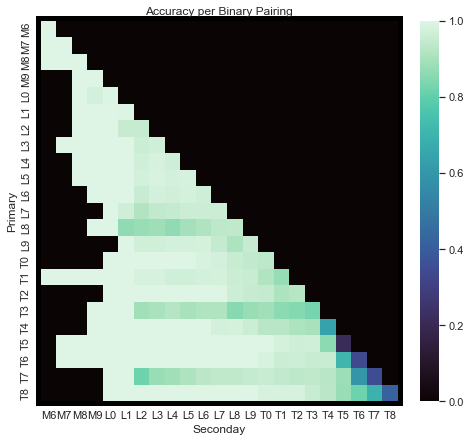

In [209]:
dataset = data(use_noise = True)
train_data, train_labels, test_data, test_labels = dataset.get_data()
experiment = run_model(train_data, train_labels, test_data, test_labels)
experiment.rf()